# 1. Loading the data

### We are going to analyze single-cell RNA-seq data that are available at the GEO database : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE121521
### Sample is here : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3438654
### Publication is here : https://www.nature.com/articles/s41564-019-0633-0

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.6


In [3]:
results_file = 'write/resultfile'

In [4]:
adata = sc.read_10x_mtx('GSM3438654', var_names='gene_symbols', cache=True)

... reading from cache file cache\GSM3438654-matrix.h5ad


## Preprocessing

### Basic filtering

In [5]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

filtered out 14371 genes that are detected in less than 10 cells


In [6]:
adata

AnnData object with n_obs × n_vars = 9296 × 13627
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

### Genes

In [7]:
adata.var

,gene_ids,n_cells
Rp1,ENSMUSG00000025900,287
Mrpl15,ENSMUSG00000033845,2587
Lypla1,ENSMUSG00000025903,2209
Tcea1,ENSMUSG00000033813,3817
Atp6v1h,ENSMUSG00000033793,1341
...,...,...
AC168977.2,ENSMUSG00000094915,41
AC168977.1,ENSMUSG00000079808,229
PISD,ENSMUSG00000095041,5478
DHRSX,ENSMUSG00000063897,2085


In [8]:
adata.var_names

Index(['Rp1', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1',
       '4732440D04Rik', 'Pcmtd1', 'Gm26901', 'Rrs1',
       ...
       'AC133103.1', 'AC132444.1', 'Csprs', 'AC125149.3', 'AC125149.2',
       'AC168977.2', 'AC168977.1', 'PISD', 'DHRSX', 'CAAA01147332.1'],
      dtype='object', length=13627)

## Observations

In [9]:
adata.obs.head(10)

,n_genes
AAACCTGAGAAGGTGA-1,1826
AAACCTGAGATCGATA-1,1742
AAACCTGAGCTGCGAA-1,979
AAACCTGAGTGTGGCA-1,2370
AAACCTGCAGGGTATG-1,2191
AAACCTGCATGCCTAA-1,2892
AAACCTGCATGGTCAT-1,1585
AAACCTGCATTACCTT-1,2262
AAACCTGCATTCGACA-1,2350
AAACCTGGTCCAGTGC-1,1592


## Unstructured data

It will be empty for now

In [10]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

## Matrix

In [11]:
adata.X

<9296x13627 sparse matrix of type '<class 'numpy.float32'>'
	with 18268821 stored elements in Compressed Sparse Row format>

### Show those genes that yield the highest fraction of counts in each single cell, across all cells

normalizing counts per cell
    finished (0:00:00)


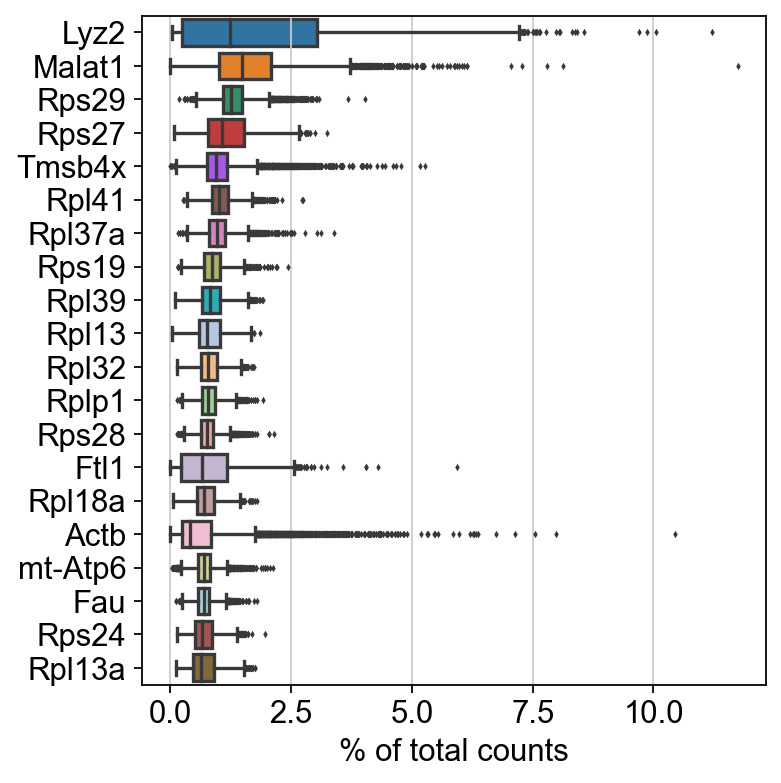

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 2. Visualize and filter out poor-quality cells

In single cell analysis, mitochondrial DNA is highly detected in dying cells. We want to remove those bad quality cells.

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var

,gene_ids,n_cells,mt
Rp1,ENSMUSG00000025900,287,False
Mrpl15,ENSMUSG00000033845,2587,False
Lypla1,ENSMUSG00000025903,2209,False
Tcea1,ENSMUSG00000033813,3817,False
Atp6v1h,ENSMUSG00000033793,1341,False
...,...,...,...
AC168977.2,ENSMUSG00000094915,41,False
AC168977.1,ENSMUSG00000079808,229,False
PISD,ENSMUSG00000095041,5478,False
DHRSX,ENSMUSG00000063897,2085,False


In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [15]:
adata.obs

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCTGAGAAGGTGA-1,1826,1825,7.509883,6109.0,8.717682,243.0,5.497168,3.977738
AAACCTGAGATCGATA-1,1742,1741,7.462789,6796.0,8.824237,267.0,5.590987,3.928782
AAACCTGAGCTGCGAA-1,979,979,6.887553,3589.0,8.185907,90.0,4.510859,2.507662
AAACCTGAGTGTGGCA-1,2370,2370,7.771067,10196.0,9.229849,290.0,5.673323,2.844253
AAACCTGCAGGGTATG-1,2191,2190,7.692113,8396.0,9.035630,281.0,5.641907,3.346832
...,...,...,...,...,...,...,...,...
TTTGTCATCATTGCCC-1,2543,2542,7.841100,10464.0,9.255792,387.0,5.961005,3.698395
TTTGTCATCCATGAGT-1,3320,3317,8.107117,14962.0,9.613336,432.0,6.070738,2.887315
TTTGTCATCCCATTAT-1,1061,1060,6.966967,2682.0,7.894691,57.0,4.060443,2.125280
TTTGTCATCCCATTTA-1,1085,1085,6.990257,2658.0,7.885705,111.0,4.718499,4.176073


In [16]:
adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Rp1,ENSMUSG00000025900,287,False,287,0.033240,0.032700,96.912651,309.0,5.736572
Mrpl15,ENSMUSG00000033845,2587,False,2587,0.351441,0.301172,72.170826,3267.0,8.091933
Lypla1,ENSMUSG00000025903,2209,False,2209,0.283563,0.249640,76.237091,2636.0,7.877397
Tcea1,ENSMUSG00000033813,3817,False,3817,0.574763,0.454105,58.939329,5343.0,8.583730
Atp6v1h,ENSMUSG00000033793,1341,False,1341,0.162651,0.150702,85.574441,1512.0,7.321850
...,...,...,...,...,...,...,...,...,...
AC168977.2,ENSMUSG00000094915,41,False,41,0.004518,0.004508,99.558950,42.0,3.761200
AC168977.1,ENSMUSG00000079808,229,False,229,0.029260,0.028840,97.536575,272.0,5.609472
PISD,ENSMUSG00000095041,5478,False,5478,1.163404,0.771683,41.071429,10815.0,9.288782
DHRSX,ENSMUSG00000063897,2085,False,2085,0.268287,0.237668,77.570998,2494.0,7.822044


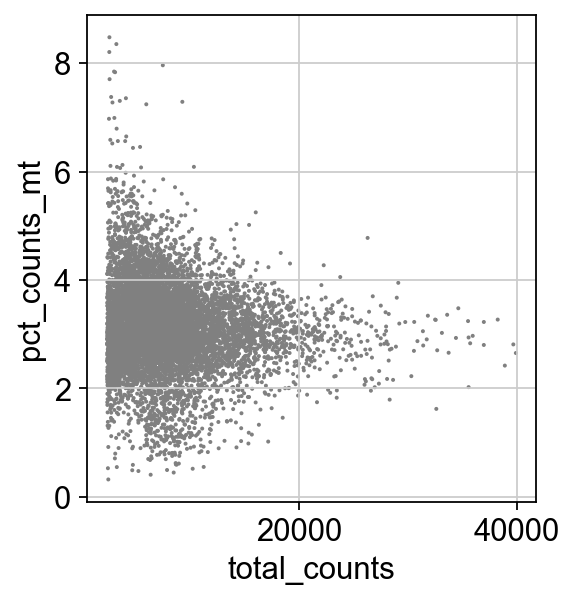

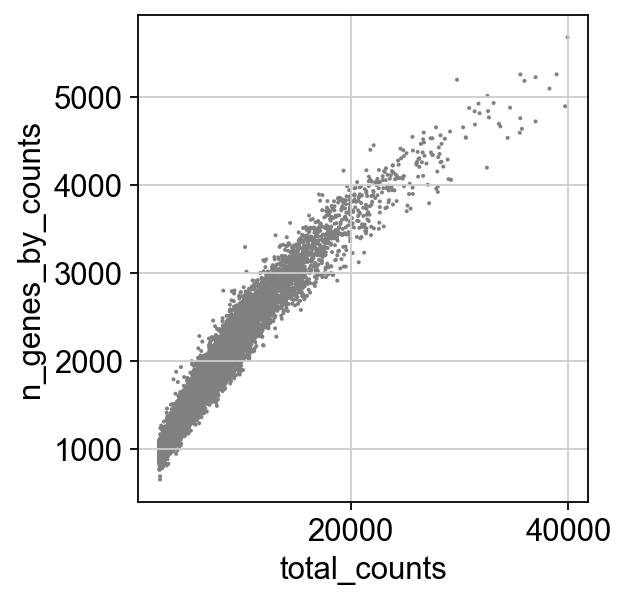

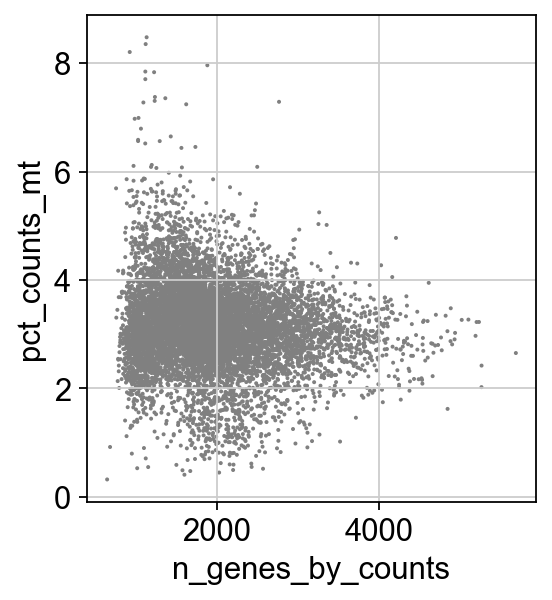

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

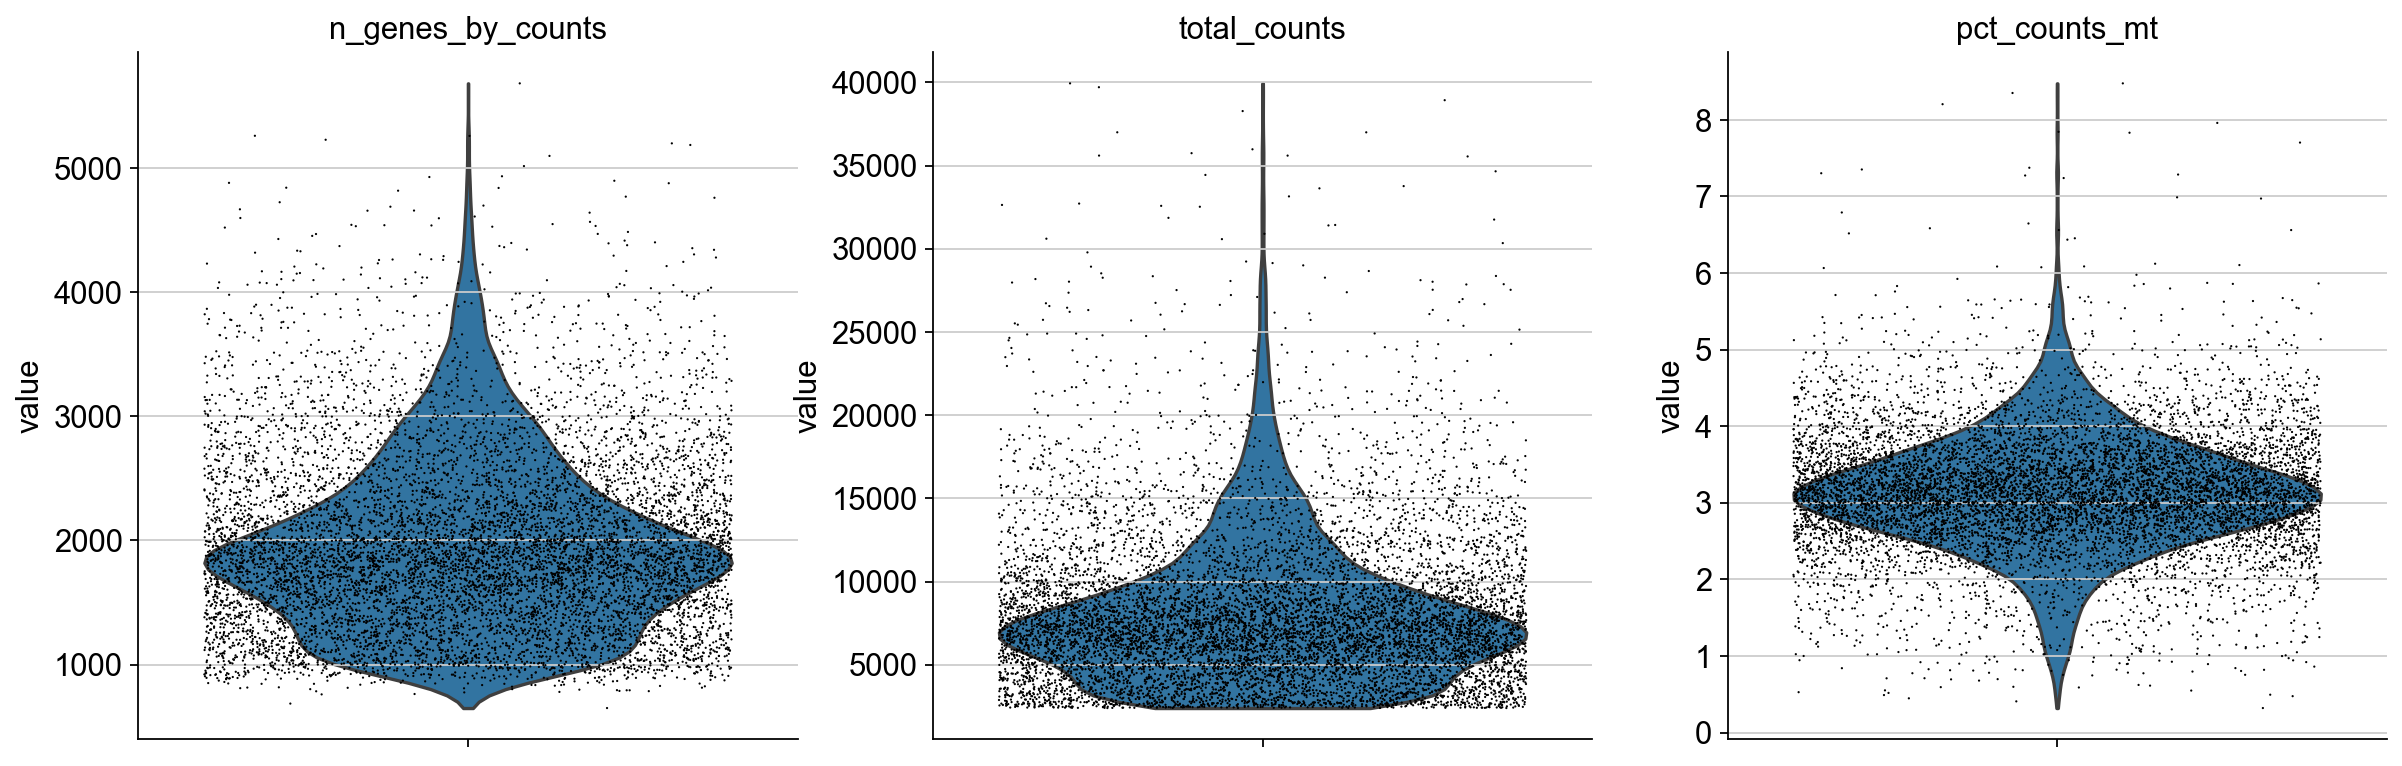

In [18]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [19]:
adata = adata[adata.obs.n_genes_by_counts > 900, :].copy()
adata = adata[adata.obs.pct_counts_mt < 4.5, :].copy()

adata

AnnData object with n_obs × n_vars = 8800 × 13627
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

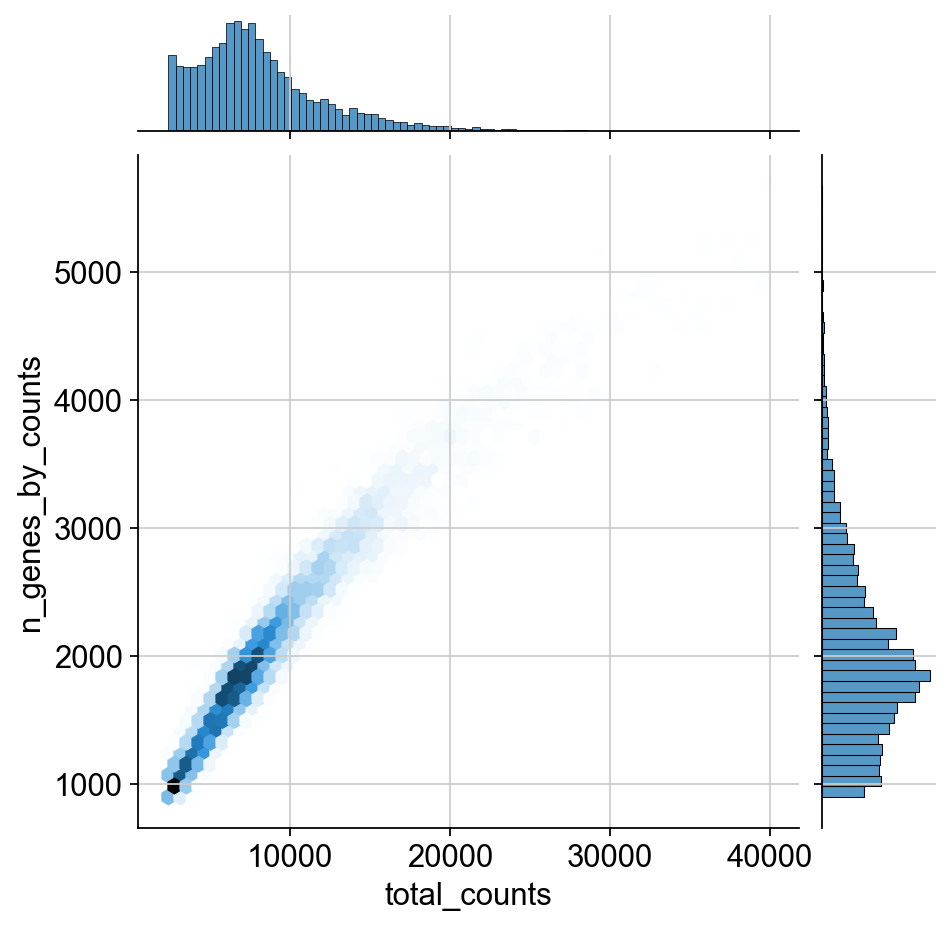

In [20]:
import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

# 3. Normalize and scale the data

In [21]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,1.0,20.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,...,2.0,2.0,0.0,0.0,1.0,0.0,0.0,29.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,37.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,0.0,0.0,15.0,0.0,0.0
96,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
97,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0
98,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,1.0


In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [23]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.969615,0.000000,0.000000,0.969615,0.000000,0.0,0.0,0.969615,0.0,0.000000,...,0.000000,1.452517,0.000000,0.0,0.969615,0.000000,0.969615,3.518642,0.0,0.000000
1,0.000000,0.904807,0.000000,0.000000,0.000000,0.0,0.0,1.929464,0.0,0.904807,...,1.371918,1.371918,0.000000,0.0,0.904807,0.000000,0.000000,3.776711,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.819484,0.0,0.000000
3,0.000000,0.683489,0.000000,0.000000,0.000000,0.0,0.0,0.683489,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.277152,0.0,0.000000
4,0.000000,0.784378,0.784378,0.000000,0.000000,0.0,0.0,0.784378,0.0,0.000000,...,0.000000,0.000000,0.784378,0.0,0.000000,0.000000,0.784378,3.808186,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.669236,0.000000,0.669236,0.0,0.0,0.000000,0.0,0.000000,...,0.669236,1.066601,0.000000,0.0,0.669236,0.000000,0.000000,2.727275,0.0,0.000000
96,0.000000,0.000000,1.293302,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.971113,0.0,0.000000
97,0.000000,0.000000,0.000000,0.000000,0.700221,0.0,0.0,0.700221,0.0,0.000000,...,0.700221,0.700221,0.000000,0.0,0.000000,0.000000,0.700221,3.380912,0.0,0.000000
98,0.626273,0.626273,0.000000,0.626273,0.626273,0.0,0.0,0.626273,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.267595,0.0,0.626273


normalizing counts per cell
    finished (0:00:00)


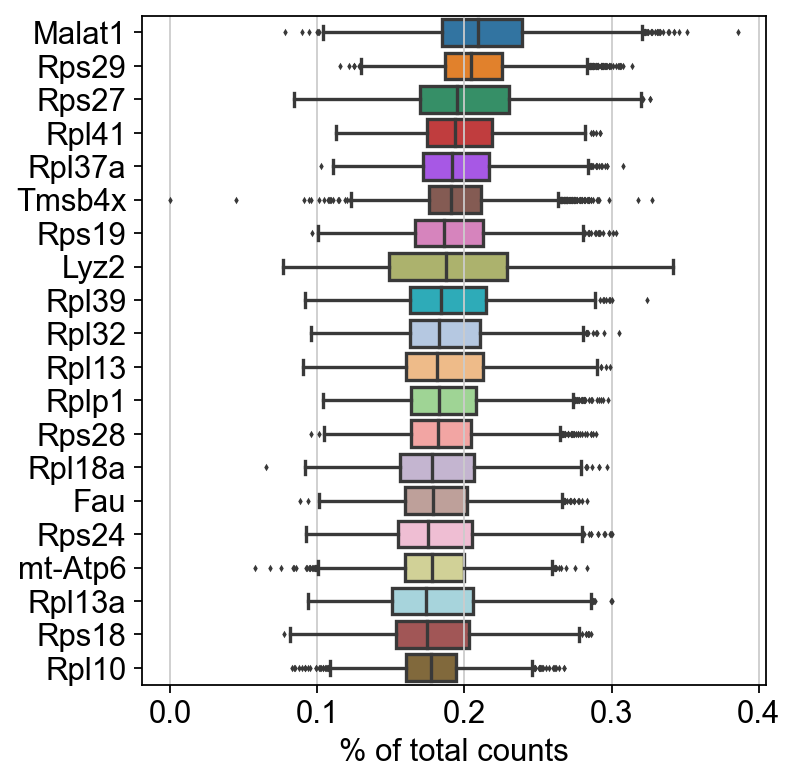

In [24]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Now our data are normalized

# 4. Identification of biologicaly variable genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


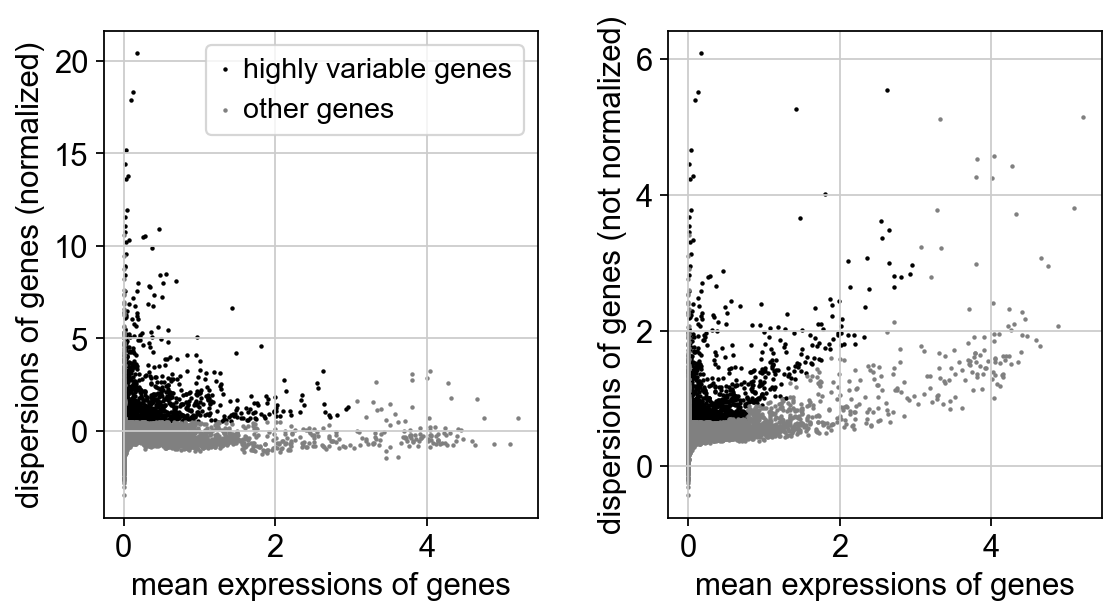

In [25]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False)

In [26]:
adata.var['highly_variable'].value_counts()

False    12387
True      1240
Name: highly_variable, dtype: int64

# 5. PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


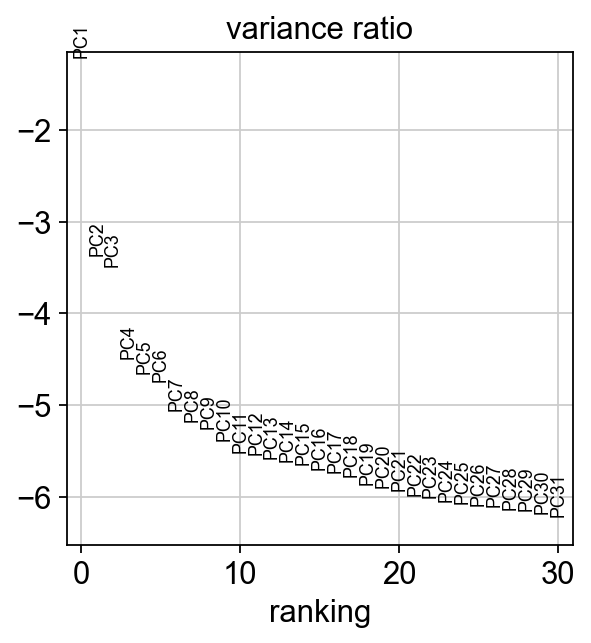

In [27]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

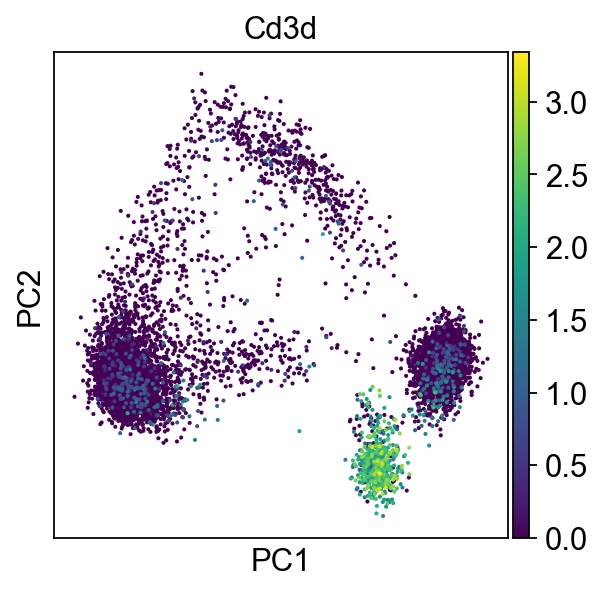

In [28]:
sc.pl.pca(adata, color='Cd3d')

### Cd3d is a T-cell surface marker and here we can see that it is expressed only in a particular cluster. We have to perform non-linear dimensionality reduction to obtain more informations.

# 6. Compute neghborhood graph and embedd it using UMAP visualization (non-linear dimensionality reduction)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30


# 7. Cells clustering

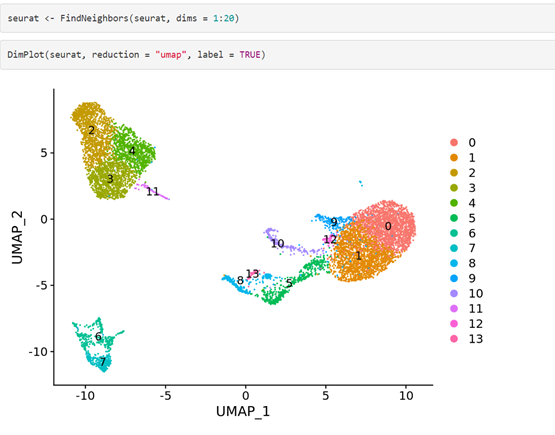

### Here is our clustering with Rstudio, we are going to have exact similar clustering, expet it's symetrically inversed but same number of cluster with the default resolution.

In [ ]:
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, color='louvain')

### Resolution is decrease to 1.0 in order to have 12 clusters, which is enough and consistent with the publication.

# 8. Visualizing gene expression in clusters

In [ ]:
sc.pl.umap(adata, color=["Cd3d", "Cd3g", "Blk", "Spib", "Ccr5", "Cd14"])

### We can see that T cells markers Cd3d and Cd3g are located in the cluster 6.
### B cells markers Blk and Spib are located in the clusters 1, 2, 3 and 4 that can be considered as a super cluster here.
### Macrophages markers Ccr5 and Cd14 are in the clusters at the opposite side of the graph.

In [ ]:
sc.pl.umap(adata, color=["Ciita", "Tap1", "H2-Ab1", "Cd163", "Cd68", "Cd84"])

### Tap1, Ciita and H2Ab1 are caracteristic markers of MHC class II. We can see that these markers are low expressed especially in macrophage's clusters (markers Cd163, Cd68 and Cd84) and also in T cells cluster. Naive T cells are not related to MHC class II. These observations seems to be a big point of the paper.

# 9. Running DGE tests to find cluster biomarkers

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

In [ ]:
sc.pl.umap(adata, color=["Cebpb", "Ebf1", "Ms4a4b"])

### CEBPB is critical for normal macrophage functionning, it expression cluster is consistent with our previous result.

### EBF1 controls the expression of key proteins required for B cell differentiation, signal transduction and function, this supercluster is essentially composed of B cells.

### MS4A4B Is a GITR-associated membrane adapter, expressed by T Cells which are in cluster 6.

### With Rstudio we can change things with different argument and parameters but the conclusion about the genes expression are the same

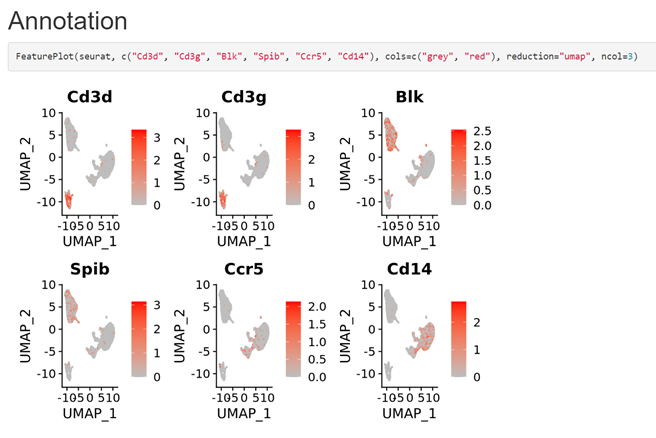

### Violin plot obtained with Rstudio, we can do that we scanpy also but we are going to show some other type of plot with it.

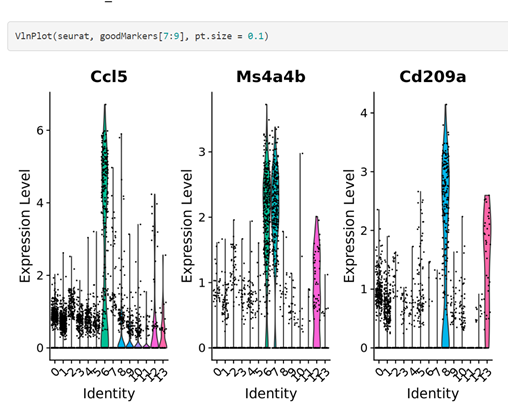

## Another clustering and change size

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, key_added='clusters', resolution=0.7)
    sc.pl.umap(adata, color='leiden', s=20)

## Extract embeddings

In [ ]:
adata.obsm

In [ ]:
df = pd.DataFrame(adata.obsm['X_pca'])

In [ ]:
df

In [ ]:
adata.X

In [ ]:
adata.var

In [ ]:
adata.obs

In [ ]:
adata.uns

### We are going to show 2 more way to visualize our expression data within scanpy. First we can use a dotplot. This type of plot summarizes two types of information: the color represents the mean expression within each of the categories (in this case in each cluster) and the dot size indicates the fraction of cells in the categories expressing a gene.

In [ ]:
marker_genes_dict = {
    'Macrophage': ['Cebpb', 'Cd14'],
    'T-cell': ['Cd3d', 'Ms4a4b'],
    'B-cell': ['Ebf1', 'Spib'],
}

In [ ]:
sc.pl.dotplot(adata, marker_genes_dict, 'clusters', dendrogram=True)

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '7': 'Macrophage',
     '2': 'B-cell',
     '4': 'T-cell',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

In [ ]:
sc.pl.dotplot(adata, marker_genes_dict, 'cell type', dendrogram=True)

In [ ]:
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

### A good way to vizualize expression data is to do a heatmap

In [ ]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)

### This various visual reprensation seems to confirm our observations and the paper results, espcially about T naive cells indepedent and MHC class 2 are low expressed macrophages clusters. To confirm that and build more robust plot we can add other markers and make conclusions about their differential expressions.

# Trajectory inference

In [ ]:
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [ ]:
adata.X = adata.X.astype('float64')

In [ ]:
sc.pp.recipe_zheng17(adata)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

## Denoising 

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [ ]:
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [ ]:
sc.tl.louvain(adata, resolution=1.0)

In [ ]:
sc.tl.paga(adata, groups='louvain')

In [ ]:
sc.pl.paga(adata, color=['louvain', 'Cebpb', 'Cd3d', 'Ebf1'])

In [ ]:
sc.pl.paga(adata, color=['louvain', 'Ms4a4b', 'Spib'])

In [ ]:
adata.obs['louvain'].cat.categories

In [ ]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [ ]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40']

### Let’s use the annotated clusters for PAGA.

In [ ]:
sc.tl.paga(adata, groups='louvain_anno')

In [ ]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')

In [ ]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Cebpb', 'Cd3d', 'Ebf1'], legend_loc='on data')

In [ ]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [ ]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [ ]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [ ]:
adata.uns['louvain_anno_colors'] = new_colors

In [ ]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '0')[0]

In [ ]:
sc.tl.dpt(adata)

In [ ]:
gene_names = ['Cebpb', 'Cd14',
              'Cd3d', 'Ms4a4b',
              'Ebf1', 'Spib']

In [ ]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

In [ ]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [ ]:
paths = [('macrophages', [12, 32, 34, 25]),
         ('T-cells', [22, 23, 24, 30]),
         ('B-cells', [26, 9, 25, 12, 9])]

In [ ]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [ ]:
adata.obs['clusters'] = adata.obs['louvain_anno']

In [ ]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [ ]:
!mkdir write

In [ ]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/res.pdf')
pl.show()

### We can see that this is just another way to cluster and visiualize our gene expression data